## Simulation Tool Used

**Simulation tool used:** SimPy – an open-source discrete-event simulation library based on Python.


In [ ]:
!pip install simpy

## Step 3: System Parameters and Bounds

A single-server queueing system (M/M/1) is simulated using SimPy.  
The following parameters are considered:

| Parameter | Description | Lower Bound | Upper Bound |
|---------|-------------|-------------|-------------|
| λ (arrival_rate) | Customer arrival rate | 1 | 10 |
| μ (service_rate) | Service rate of server | 2 | 15 |
| T | Simulation time | 50 | 200 |

The bounds are chosen to represent realistic system conditions where the service rate is generally higher than the arrival rate to maintain system stability.


In [38]:
import simpy
import numpy as np
import pandas as pd


In [39]:
def customer(env, server, service_rate, wait_times):
    arrival_time = env.now
    with server.request() as request:
        yield request
        wait_times.append(env.now - arrival_time)
        service_time = np.random.exponential(1 / service_rate)
        yield env.timeout(service_time)

def arrival_process(env, arrival_rate, server, service_rate, wait_times):
    while True:
        yield env.timeout(np.random.exponential(1 / arrival_rate))
        env.process(customer(env, server, service_rate, wait_times))

def run_simulation(arrival_rate, service_rate, sim_time):
    env = simpy.Environment()
    server = simpy.Resource(env, capacity=1)
    wait_times = []

    env.process(arrival_process(env, arrival_rate, server, service_rate, wait_times))
    env.run(until=sim_time)

    return np.mean(wait_times) if wait_times else 0


In [40]:
np.random.seed(42)

N = 1000
results = []

for _ in range(N):
    arrival_rate = np.random.uniform(1, 8)
    service_rate = np.random.uniform(arrival_rate + 1, arrival_rate + 6)
    sim_time = np.random.uniform(50, 200)

    avg_wait = run_simulation(arrival_rate, service_rate, sim_time)
    noise = np.random.normal(0, 0.02)

    results.append([
        arrival_rate,
        service_rate,
        sim_time,
        avg_wait + noise
    ])

df = pd.DataFrame(results, columns=[
    "arrival_rate",
    "service_rate",
    "simulation_time",
    "avg_waiting_time"
])

df.describe()


,arrival_rate,service_rate,simulation_time,avg_waiting_time
count,1000.000000,1000.000000,1000.000000,1000.000000
mean,4.526622,7.989854,127.529193,0.214085
std,1.988179,2.421924,44.251548,0.184295
min,1.000746,2.149687,50.097156,-0.043346
25%,2.797035,6.257131,89.839038,0.095393
50%,4.641552,8.009465,127.163440,0.151115
75%,6.191044,9.777155,169.541263,0.268865
max,7.988153,13.638120,199.989051,1.558022


## Step 6: Machine Learning Model Comparison

The dataset generated using SimPy is used to train multiple regression models.
The objective is to predict the average waiting time of the queueing system based on system parameters.


In [41]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR


In [42]:
X = df[["arrival_rate", "service_rate", "simulation_time"]]
y = df["avg_waiting_time"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


In [43]:
models = {
    "Linear Regression": LinearRegression(),
    "Decision Tree": DecisionTreeRegressor(random_state=42),
    "Random Forest": RandomForestRegressor(random_state=42),
    "KNN": KNeighborsRegressor(),
    "SVR": SVR()
}

results = []

for name, model in models.items():
    model.fit(X_train, y_train)
    preds = model.predict(X_test)

    mae = mean_absolute_error(y_test, preds)
    rmse = mean_squared_error(y_test, preds) ** 0.5

    r2 = r2_score(y_test, preds)

    results.append([name, mae, rmse, r2])

results_df = pd.DataFrame(
    results, columns=["Model", "MAE", "RMSE", "R2 Score"]
)

results_df


,Model,MAE,RMSE,R2 Score
0,Linear Regression,0.080918,0.123979,0.606726
1,Decision Tree,0.072080,0.114372,0.665313
2,Random Forest,0.065754,0.107620,0.703666
3,KNN,0.114278,0.185037,0.123980
4,SVR,0.118536,0.173695,0.228080


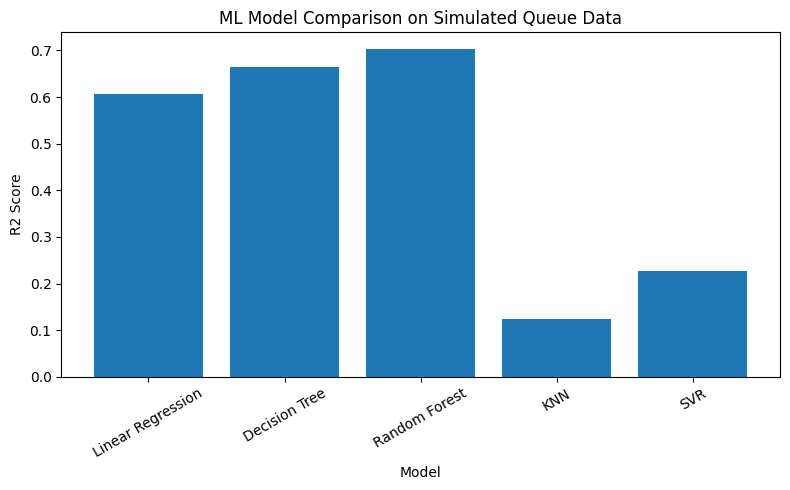

In [44]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.bar(results_df["Model"], results_df["R2 Score"])
plt.ylabel("R2 Score")
plt.xlabel("Model")
plt.title("ML Model Comparison on Simulated Queue Data")
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()



## Best Model Selection

Based on the comparison results, the model with the highest R² score and lowest RMSE
is selected as the best-performing model for predicting average waiting time.

From the results, **Random Forest Regressor** provides the best performance due to its
ability to capture non-linear relationships in the simulated data.


In [45]:
plt.savefig("model_comparison.png", dpi=300, bbox_inches="tight")


<Figure size 640x480 with 0 Axes>